## Hi Guys! Today, I have chosen an important problem statement to work upon. Let me break it down into simple words, and you will soon understand its importance.  

### -  Financial institutions invest a ton of money for constructing credit risk analysis models to determine the probability of default of a potential borrower. The models provide information on the level of a borrower's credit risk at any particular time. 

### -  Some of you might be wondering what "credit" is. Well here's come the definition:

<div style="width:100%;text-align: center;"> <img align=middle src="https://www.greenbiz.com/sites/default/files/2020-09/definition_conceptart.jpg" alt="Heat beating" style="height:300px;margin-top:3rem;"> </div>

### <span style="color:red;"> - "Credit is the ability to borrow money or access goods or services with the understanding that you'll pay later." </span>

### <span style="color:blue;"> - "Creditworthiness is how a lender determines that you will default on your debt obligations, or how worthy you are to receive new credit. Your creditworthiness is what creditors look at before they approve any new credit to you." </span>

### Credit risks are a commonly observed phenomenon in areas of finance that relate to mortgages, credit cards, and other kinds of loans. There is always a probability that the borrower may not get back with the amount.

So it is important that when a borrower applies for a loan, the lender or the issuer must establish and examine the borrower’s ability to repay the loan. So in this notebook, I will be doing the following stuff:

1. Exploring the Dataset(**EDA**)
2. Applying **Oversampling** Techniques
3. Test all machine learning models with **Cross Validation**
4. **Hyperparameter tune** the best model
5. Analyse the best model with the help of relevant **Metrics** 
6. **Pickling** the best model 
7. Creating an **UI**(User Interface) with the help of **Streamlit** 
8. **Deployment** on **Heroku** platform
9. A sample prediction will be made to test the application

The 7th and 8th steps will be shown and explained with the help of screenshots.

Importing the necessary header files:

In [61]:
## Basic Libraries:
import pandas as pd
pd.options.display.max_colwidth=150   ## this is used to set the column width.

## Note: Other available must know options are:
# pd.options.display.max_rows=x  ## controls the max rows to be displayed on screen
# pd.options.display.max_columns=x  ## controls the max columns to be displayed on screen
# pd.options.display.precision=x  ## controls the precision of each floating points to be displayed on screen
# pd.options.display.float_format = '{:.2f}%'.format  ## controls the format of displaying numbers on screen. 
                                                      ## For eg.{$(:,.2f)} can be used for currency

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

plt.style.use('fivethirtyeight') ## Setting the Style

## For making sample data:
from sklearn.datasets import make_classification

## For Preprocessing: 
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Using imblearn library:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Using msno Library for Missing Value analysis:
import missingno as msno

## For Metrics:
from sklearn.metrics import plot_precision_recall_curve,accuracy_score 
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

## For Machine Learning Models:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

## For Feature Importance:
!pip install shap
import shap

In [2]:
## Setting the seed to allow reproducibility
np.random.seed(31415)

# 1. Exploring the Dataset(EDA)

## About the Dataset:

### The dataset consists of the following features:

#### Independent Variables:

- Name:	Description

- person_age:	Age of the person 

- person_income:	Annual Income

- personhomeownership:	Home ownership

- personemplength:	Employment length (in years)

- loan_intent:	Loan intent

- loan_grade:	Loan grade

- loan_amnt:	Loan amount

- loanintrate:	Interest rate

- loanpercentincome:	Percent income

- cbpersondefaultonfile:	Historical default

- cbpresoncredhistlength:	Credit history length

#### Target Variable:

- loan_status:	Loan status (0 is non-default/1 is default)

### Reading the dataset:

In [3]:
df = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.shape[0],df.shape[1]

(32581, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [7]:
## Checking for Duplicates
dups = df.duplicated()
dups.value_counts() #There are 165 Duplicated rows

False    32416
True       165
dtype: int64

In [8]:
## Removing the Duplicates
print(f"Shape of Data before removing duplicates -----> ({df.shape[0]},{df.shape[1]}) \n")
df.drop_duplicates(inplace=True)
print(f"Shape of Data after removing duplicates -----> ({df.shape[0]},{df.shape[1]})")

Shape of Data before removing duplicates -----> (32581,12) 

Shape of Data after removing duplicates -----> (32416,12)


In [9]:
ccol=df.select_dtypes(include=["object"]).columns
ncol=df.select_dtypes(include=["int","float"]).columns

print("The number of Categorical columns are:",len(ccol))
print("The number of Numerical columns are:",len(ncol))

The number of Categorical columns are: 4
The number of Numerical columns are: 8


Printing the different columns with their cardinality (number of unique elements in each column):

In [10]:
print("The NUMERICAL columns are:\n")
for i in ncol:
    print("->",i,"-",df[i].nunique())
    
print("\n---------------------------\n")
print("The CATEGORICAL columns are:\n")
for i in ccol:
    print("->",i,"-",df[i].nunique())

The NUMERICAL columns are:

-> person_age - 58
-> person_income - 4295
-> person_emp_length - 36
-> loan_amnt - 753
-> loan_int_rate - 348
-> loan_status - 2
-> loan_percent_income - 77
-> cb_person_cred_hist_length - 29

---------------------------

The CATEGORICAL columns are:

-> person_home_ownership - 4
-> loan_intent - 6
-> loan_grade - 7
-> cb_person_default_on_file - 2


- Analysing the Target variable:

In [11]:
df["loan_status"].value_counts(normalize=True)

0    0.781312
1    0.218688
Name: loan_status, dtype: float64

The Data is highly **IMBALANCED**. We will deal with oversampling techniques like KNN-SMOTE to solve this issue.

- Checking for Missing Data:

Missing data, or missing values, occur when you don’t have data stored for certain variables or participants. Data can go missing due to incomplete data entry, equipment malfunctions, lost files, and many other reasons.

There are typically 3 types of missing values:

1. Missing completely at random (MCAR)

2. Missing at random (MAR)

3. Missing not at random (MNAR)

Problems:

Missing data are problematic because, depending on the type, they can sometimes cause sampling bias. This means your results may not be generalizable outside of your study because your data come from an unrepresentative sample.

In [12]:
## Checking for Missing values:
df.isnull().any()

person_age                    False
person_income                 False
person_home_ownership         False
person_emp_length              True
loan_intent                   False
loan_grade                    False
loan_amnt                     False
loan_int_rate                  True
loan_status                   False
loan_percent_income           False
cb_person_default_on_file     False
cb_person_cred_hist_length    False
dtype: bool

In [13]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

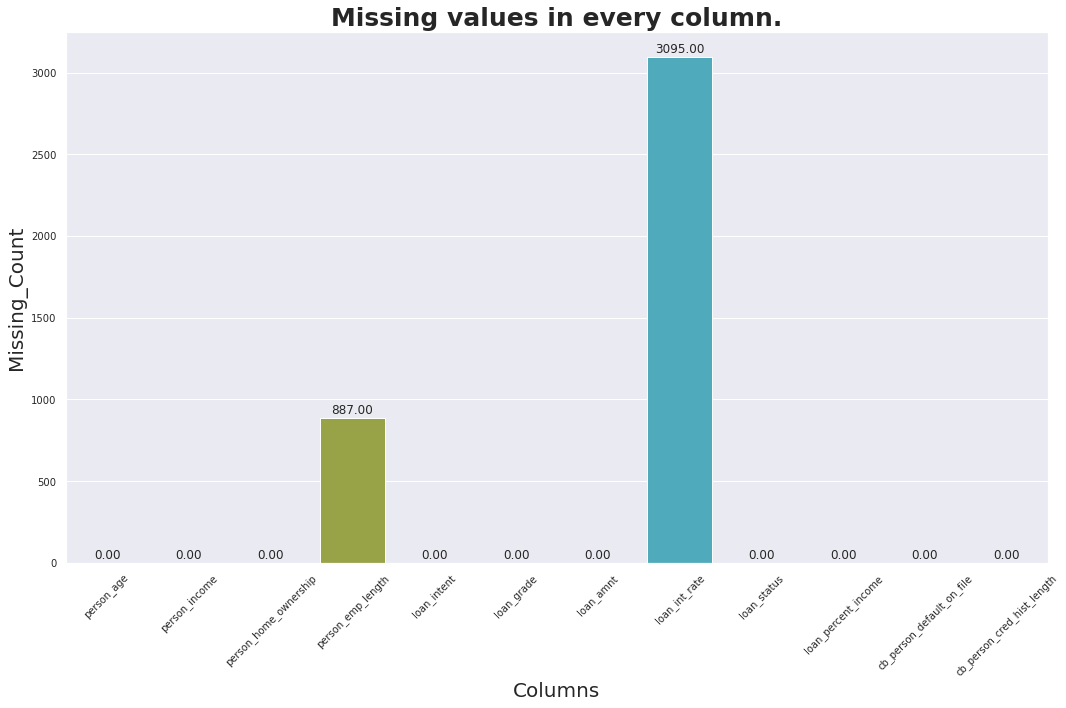

In [14]:
mn=df.isna().sum()
mn=pd.DataFrame(mn,columns=["missing_count"]).reset_index()
mn.columns=["columns_names","missing_count"]
mn

sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,10))
plots=sns.barplot(x=mn.columns_names,y=mn.missing_count)
# Iterating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.xticks(rotation=45) #Rotating the Label
plt.title("Missing values in every column.",size=25,weight="bold") #Title of the plot
plt.xlabel("Columns",fontsize=20) #Title of x-axis
plt.ylabel("Missing_Count",fontsize=20)
plt.tick_params(labelsize=10) #Varying label size
plt.tight_layout()

Using missing number visualiser to review the missing data:

- On the left side of the plot, the y-axis scale ranges from 0.0 to 1.0, where 1.0 represents 100% data completeness. If the bar is less than this, it indicates that we have missing values within that column.

- On the right side of the plot, the scale is measured in index values. With the top right representing the maximum number of rows within the dataframe.

- Along the top of the plot, there are a series of numbers that represent the total count of the non-null values within that column.

<AxesSubplot:>

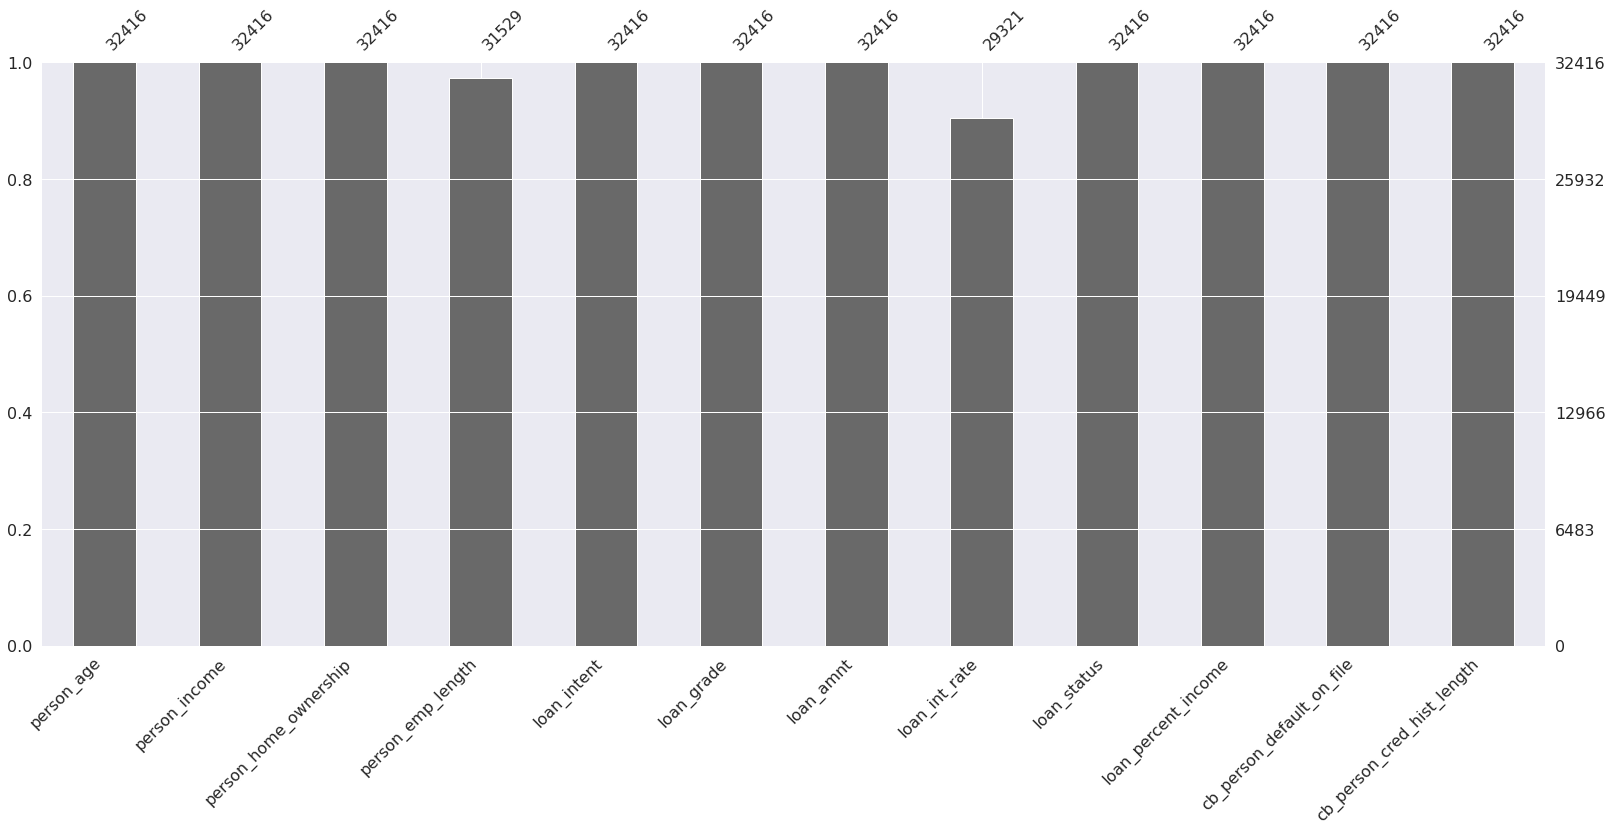

In [15]:
msno.bar(df)

- The matrix plot is a great tool if you are working with depth-related data or time-series data. It provides a colour fill for each column. When data is present, the plot is shaded in grey (or your colour of choice), and when it is absent the plot is displayed in white.

<AxesSubplot:>

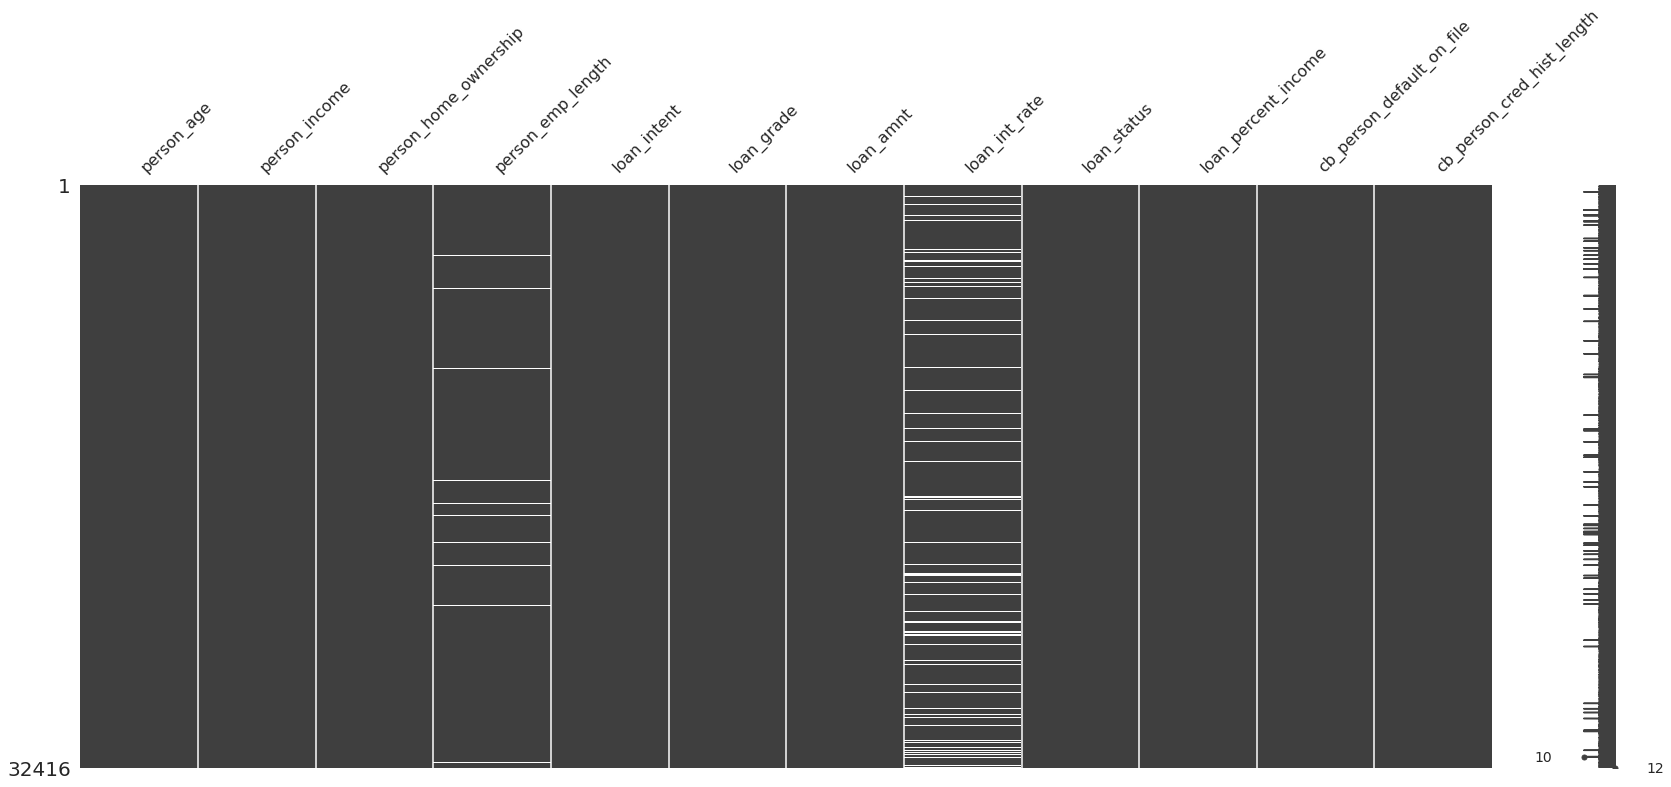

In [16]:
msno.matrix(df)

- The heatmap is used to identify correlations of the nullity between each of the different columns. 

Here no correlation is detected between columns having missing values.

<AxesSubplot:>

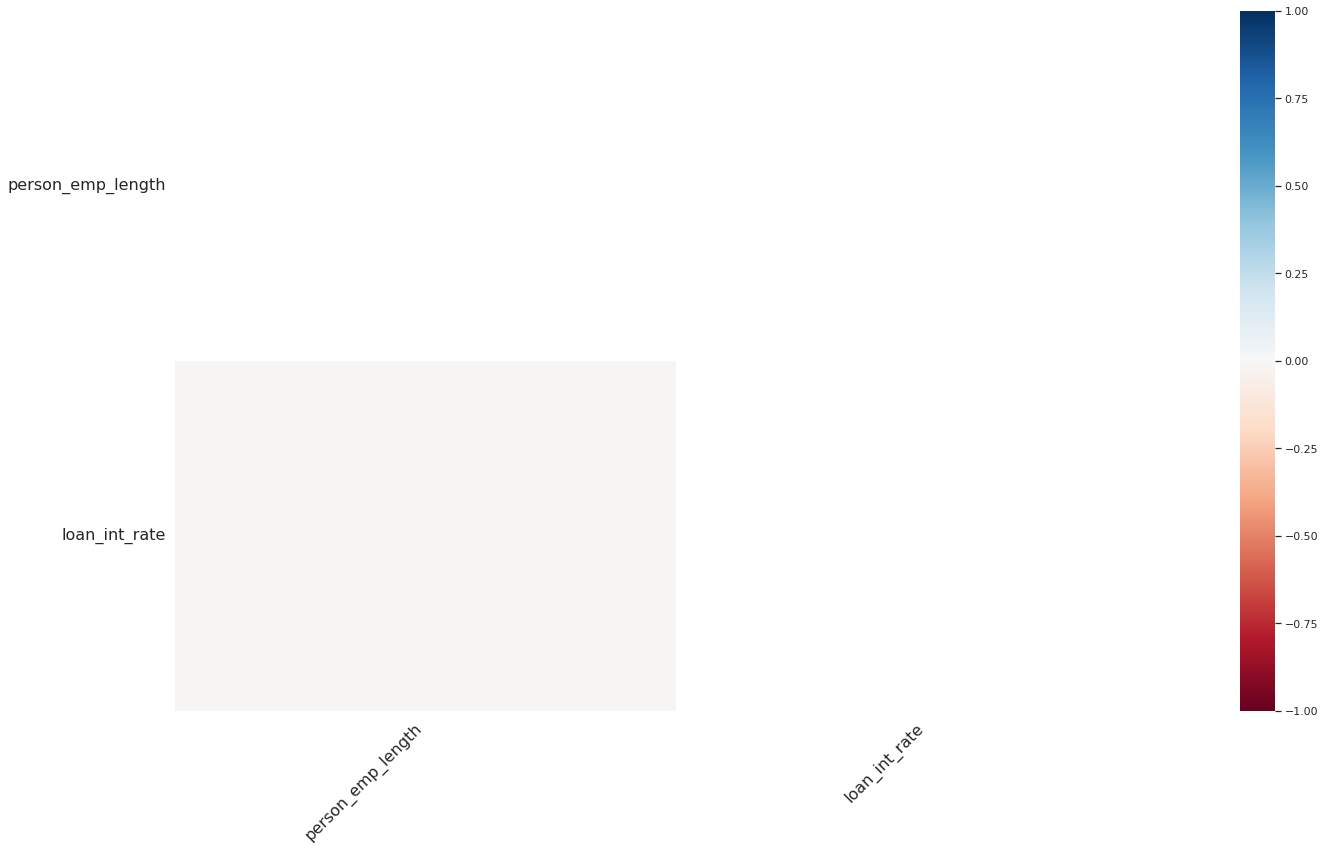

In [17]:
msno.heatmap(df)

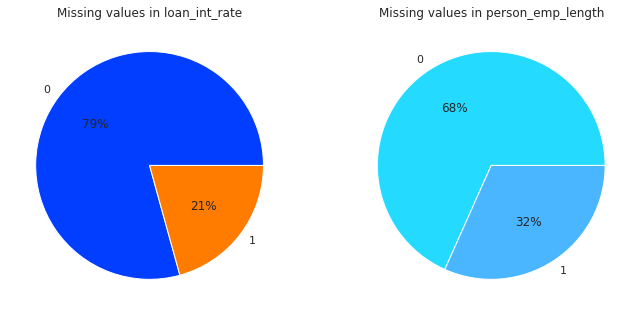

In [18]:
## Missing values in each target class:
l=df.groupby(["loan_status"])["loan_int_rate"].apply(lambda x:x.isnull().sum())
p=df.groupby(["loan_status"])["person_emp_length"].apply(lambda x:x.isnull().sum())

fig,ax=plt.subplots(1,2,figsize=(10,10))
ax[0].set_title("Missing values in loan_int_rate")
ax[0].pie(l.values, labels=l.index, colors=sns.color_palette('bright'), autopct='%.0f%%')

ax[1].set_title("Missing values in person_emp_length")
ax[1].pie(p.values, labels=p.index, colors=sns.color_palette('cool'), autopct='%.0f%%')
fig.show()

Still to do:

1. Splitting
2. Iterative Imputation   ## done after splitting
3. Oversampling  ## done after splitting

NOTE: EVERY PREPROCESSING TECHNIQUE IS DONE ONLY ONE THE TRAIN SET. SO SPLITTING IS MANDATORY BEFORE OUTLIER REMOVAL, MISSING VALUES HANDLING, OVERSAMPLING, ETC...

Time to handle the missing values. First we will split the data:

In [19]:
# X and y will represent the entire training data
# X_test and y_test will be the sample data for model evaluation

X, X_test, y, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

We have stratified sampled the data (checking the proportion of the target variable):

In [20]:
y.value_counts(normalize=True)   #Note that the proportion remains the same because of stratify.

0    0.781313
1    0.218687
Name: loan_status, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

0    0.781308
1    0.218692
Name: loan_status, dtype: float64

The proportion is preserved!

In [22]:
## Checking for missing values in train data:
(X.shape[0]-X.dropna().shape[0])/X.shape[0]*100
## There are 12% missing data in the train set

12.220422643837729

In [23]:
#To print the number of unique values:
for col in X:
    print(col, '--->', X[col].nunique())
    if X[col].nunique()<20:
        print(X[col].value_counts(normalize=True)*100)
    print()

person_age ---> 58

person_income ---> 3680

person_home_ownership ---> 4
RENT        50.320068
MORTGAGE    41.439149
OWN          7.916859
OTHER        0.323924
Name: person_home_ownership, dtype: float64

person_emp_length ---> 36

loan_intent ---> 6
EDUCATION            19.809502
MEDICAL              18.787598
VENTURE              17.542033
PERSONAL             16.878760
DEBTCONSOLIDATION    15.968687
HOMEIMPROVEMENT      11.013420
Name: loan_intent, dtype: float64

loan_grade ---> 7
A    32.932284
B    32.126330
C    19.902052
D    11.121394
E     3.004010
F     0.732685
G     0.181243
Name: loan_grade, dtype: float64

loan_amnt ---> 710

loan_int_rate ---> 346

loan_percent_income ---> 75

cb_person_default_on_file ---> 2
N    82.392411
Y    17.607589
Name: cb_person_default_on_file, dtype: float64

cb_person_cred_hist_length ---> 29



Removing Outliers based on Domain Knowledge:

- Using common sense, we can exclude rows whose age is >80.

In [24]:
X.loc[X['person_age']>=80, :]  

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32422,80,64000,RENT,7.0,MEDICAL,B,6800,11.71,0.11,N,25
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3
32416,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27
747,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25


In [25]:
X.shape   ## shape before removal

(25932, 11)

In [26]:
X = X.loc[X['person_age']<80, :]

In [27]:
X.shape  ## shape after removal

(25924, 11)

- We can also exclude rows whose work experience is >60 (Assuming average Upper bound of employement).

In [28]:
X.loc[X['person_emp_length']>=60, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3


In [29]:
X = X.loc[X['person_emp_length']<60, :]

In [30]:
# Since we've removed some data from X, we need to pass on these updations to y as well,
# as y doesn't know some of its corresponding X's have been deleted.
y = y[X.index]

Checking the distribution of the Target variable:

In [31]:
y.value_counts()

0    19744
1     5452
Name: loan_status, dtype: int64

## Part 1:

Use Column Transformer and Pipeline to streamline process

Use Randomized Search to find optimal set of parameters

Automate the procedure for multiple classifiers

Plot Precision-Recall Curve

Plot Learning Curve (for bias-variance tradeoff / check for overfitting-underfitting)

## Part 2:

Rectify existing model based on inferences from the learning curve and make a better one

### Creating Pipelines:

The Main Pipeline will be made of **two** parts:

- Preprocessing for **NUMERICAL VARIABLES**:

1. **Iterative imputer** - To handle missing values    
2. **SMOTE** - To handle imbalance in the dataset
3. **Scaling** - To maintain the scale among features

- Preprocessing for **CATEGORICAL VARIABLES**:

1. **One Hot Encoder** - To encode each categoric for model interpretability

The bottom code snippet is a small picture for something big to come. 

**NOTE:** It is always important for any Data Scientist to try out their methods and solutions on smaller data(readily available data), before they can actually dwelve into their own dataset. This will make it easier to debug code.

Sample Test Code:

In [32]:
# ## Making artificial data with the help of sklearn's make_classification method:
# X,y=make_classification(10000,20,n_classes=2,weights=[0.75])

# ## Gives count of each target's class:
# uni,cnt=np.unique(y,return_counts=True)
# for i,(j,k) in enumerate(zip(uni,cnt)):
#     print(j,"--",k)

# X=pd.DataFrame(X)

# ## Function to select random indexes:
# def create_index(nrows):
#     l=np.random.randint(0,nrows,50)
#     return l

# ## Making some rows as Null.
# for i in range(X.shape[1]):
#     X.iloc[create_index(X.shape[0]),i]=None
    
# ## To check the null values in every column:
# X.isnull().sum()

# ## Splitting:
# X_train,X_test,y_train,y_test=train_test_split(X,y)

# ## Making sample pipeline
# over = SMOTE() ## Object for smote #sampling_strategy=0.1
# model = DecisionTreeClassifier()
# steps = [('impute', IterativeImputer()),('over', over),('model', model)]
# pipeline = Pipeline(steps=steps)

# pipeline.fit(X_train,y_train)

# res=pipeline.predict(X_test)

# print(f"The accuracy of the Decision Tree Model is:{accuracy_score(y_test,res)}")

#### In this notebook, I am primarily testing the performance of **XGBoost** and **LightGBM** models, along with hyperparameter tuning. 

#### The following table presents you with the most important available hyperparameters of Extreme Gradient Boosting Machines(XGBM):

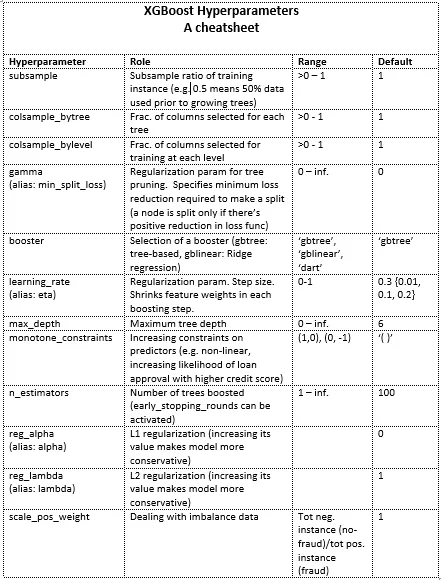

In [33]:
### 1. Creating a pipeline for numerical columns:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),     #MICE (Multivariate Imputation by Chained Equations)
    ('scale', StandardScaler()),
])

### 2. Using the Column Transformer class for binding the above numeric pipeline and
###    the preprocessing steps of categorical columns:
ct = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
], remainder='passthrough')

model=XGBClassifier()

pipe = Pipeline([
('coltf', ct),       #ct for the column transformer for preprocessing
('model', model)
])

pipe.fit(X,y)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8aa468a1d0>),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer...
                               gamma=0, gpu_id=-1, grow_policy='dep

In [34]:
preds=pipe.predict(X_test)

In [35]:
accuracy_score(y_test,preds)

0.9335286859962986

In [43]:
grid={XGBClassifier():
    {'model__n_estimators':[i*100 for i in range(10)],
     'model__max_depth':[6,8,10,12,14,16],
     'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]}   
}

gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',verbose=3, n_iter=4, random_state=0,n_jobs=-1)

print("Fitting!!")
gs.fit(X, y)

print("Gathering Results!!")
all_res = pd.DataFrame(gs.cv_results_)
model="XGB"
temp = all_res.loc[:, ['params', 'mean_test_score']]
algo_name = str(model).split('(')[0]
temp['algo'] = algo_name

Fitting!!
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [44]:
temp

,params,mean_test_score,algo
0,"{'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.3, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.934394,XGB
1,"{'model__n_estimators': 900, 'model__max_depth': 8, 'model__learning_rate': 0.15, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.935744,XGB
2,"{'model__n_estimators': 500, 'model__max_depth': 16, 'model__learning_rate': 0.05, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.936696,XGB
3,"{'model__n_estimators': 300, 'model__max_depth': 14, 'model__learning_rate': 0.01, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.932092,XGB


In [45]:
## Original Pipeline:

### 1. Creating a pipeline for numerical columns:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),     #MICE (Multivariate Imputation by Chained Equations)
    ('scale', StandardScaler()),
])

### 2. Using the Column Transformer class for binding the above numeric pipeline and
###    the preprocessing steps of categorical columns:
### Here, for keeping a list of numeric and categorical columns, I have used the make_column_selector method. You can read more 
### about it here: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html
ct = ColumnTransformer([
    ('num_pipe', num_pipe, make_column_selector(dtype_include=np.number)),
    ('cat_cols', OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
], remainder='passthrough')


## Setting up the models to be tested upon and the parameters for their pipelines'::
grid = {
    XGBClassifier():
    {'model__n_estimators':[i*100 for i in range(10)],
     'model__max_depth':[6,8,10,12,14,16],
     'model__learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0), #coltf is the name of the final 
                                        KNeighborsRegressor()]},                                      #pipeline. The base estimator of 
                                                                                                #iterative imputer is also considered
    LGBMClassifier(class_weight='balanced', random_state=0):                                          # as a parameter
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]}    
#     RandomForestClassifier(random_state=0, class_weight='balanced'):
#     {'model__n_estimators':[300,400,500],
#      'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), 
#                                         KNeighborsRegressor()]},                                       
                                                                                                       
#     KNeighborsClassifier(n_jobs=-1):
#     {'model__n_neighbors':[4,5,6,7,8,9],
#      'model__weights':['uniform', 'distance'],        
#      'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
#                                         KNeighborsRegressor()]}   
}

Printing out the parameters:

In [54]:
for i,(clf, param) in enumerate(grid.items()):
    print(f"{i+1}. {clf}")
    print(f"\nList of Hyperparameters: {param}")
    print('-'*50)

1. XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)

List of Hyperparameters: {'model__n_estimators': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900], 'model__max_depth': [6, 8, 10, 12, 14, 16], 'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3], 'coltf__num_pipe__impute__estimator': [LinearRegressi

#### Finding the optimal model and its best hyperparameters using Randomized Search and Cross-Validation(**RandomizedSearchCV**):

In [55]:
full_df = pd.DataFrame()
best_algos = {}

for model, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),       #ct for the column transformer for preprocessing
    ('model', model)
])
    print(f"Training {model}!!\n")
    ## Conducting a Randomized Search to find the best optimal hyperparamaters:
    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',verbose=3, n_iter=4, random_state=0)
    
    print("Fitting!!\n")
    gs.fit(X, y)
    
    print("Gathering Results!!\n")
    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(model).split('(')[0]
    temp['algo'] = algo_name
    
    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)!!

Fitting!!
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END coltf__num_pipe__impute__estimator=RandomForestRegressor(random_state=0), model__learning_rate=0.3, model__max_depth=10, model__n_estimators=400;, score=0.932 total

Displaying the best performed model:

In [56]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
2,"{'model__n_estimators': 500, 'model__max_depth': 16, 'model__learning_rate': 0.05, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.936696,XGBClassifier
1,"{'model__n_estimators': 900, 'model__max_depth': 8, 'model__learning_rate': 0.15, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.935744,XGBClassifier
0,"{'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.3, 'coltf__num_pipe__impute__estimator': RandomForestRegressor(rand...",0.934394,XGBClassifier
3,"{'model__n_estimators': 300, 'model__max_depth': 14, 'model__learning_rate': 0.01, 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}",0.932092,XGBClassifier
7,"{'model__n_estimators': 300, 'model__learning_rate': 0.1, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': KNeighborsRegresso...",0.920900,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_rate': 0.01, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': LinearRegression()}",0.912446,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_rate': 0.001, 'model__boosting_type': 'gbdt', 'coltf__num_pipe__impute__estimator': RandomForestRegr...",0.910978,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_rate': 0.001, 'model__boosting_type': 'dart', 'coltf__num_pipe__impute__estimator': KNeighborsRegres...",0.902643,LGBMClassifier


In [57]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 500,
 'model__max_depth': 16,
 'model__learning_rate': 0.05,
 'coltf__num_pipe__impute__estimator': KNeighborsRegressor()}

In [59]:
## Getting the hyperparameters of the best XGB Algorithm:
be = best_algos['XGBClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=KNeighborsRegressor())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8a9f923c90>),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <skle...
                               gamma=0, gpu_id=-1, grow_policy='dep

**Repeated k-Fold Cross-Validation** provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

We will use this technique here to test model performance once again before evaluating it.

In [64]:
## Testing the best pipeline:
pipe = be
# evaluate pipeline using k-fold cross validation:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores.mean()

0.9364317109613796

In [65]:
## Fitting into best pipeline for evaluation:
pipe.fit(X, y)
## Getting predictions:
preds = pipe.predict(X_test)
## Getting probabilities:
probs = pipe.predict_proba(X_test)

In [71]:
accuracy_score(y_test,preds)

0.9349167180752622

Viewing the probabilities obtained for the test data:

In [66]:
probs

array([[9.9991244e-01, 8.7533874e-05],
       [5.7011843e-04, 9.9942988e-01],
       [9.7010785e-01, 2.9892154e-02],
       ...,
       [9.8005074e-01, 1.9949265e-02],
       [9.8983520e-01, 1.0164816e-02],
       [9.8917514e-01, 1.0824881e-02]], dtype=float32)

### Learning Curve:

Plotting the learning curve is important to analyse whether the model is generalising properly.

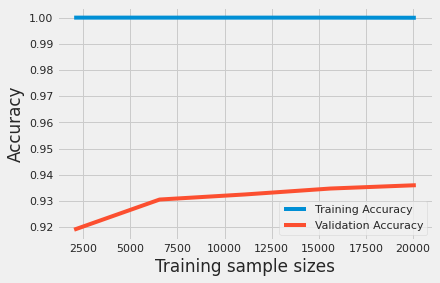

In [67]:
%%time
def funct_lc(be,X_train,y_train):
    a, b, c = learning_curve(be, X_train, y_train, n_jobs=-1, scoring='accuracy')
    plt.plot(a, b.mean(axis=1), label='Training Accuracy')
    plt.plot(a, c.mean(axis=1),  label='Validation Accuracy')
    plt.xlabel('Training sample sizes')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
funct_lc(be,X,y)

### Evaluating the results of the best model:

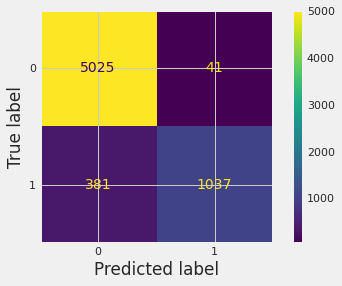

In [68]:
## Function for confusion matrix:
def funct_cm(be,X_test,y_test,preds):
    ## Simple Confusion Matrix:
    confusion_matrix(y_test, preds)
    
    ## Plotting the Confusion Matrix:
    plot_confusion_matrix(be, X_test, y_test)
    
    ## Classification Report:
    classification_report(y_test, preds)
    
    ## Accuracy Score
    be.score(X_test, y_test)
    
funct_cm(be,X_test,y_test,preds)

### Final Accuracy on test set is 93.64%

### Plotting the Precision-Recall Curve:

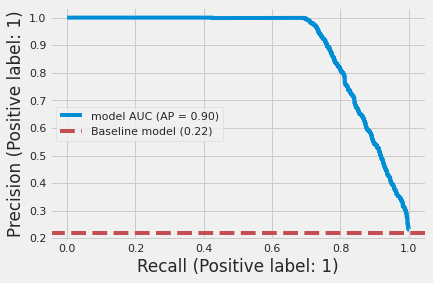

In [69]:
%%time
def funct_pr(be,X_test,y_test):
    plot_precision_recall_curve(estimator=be, X=X_test, y=y_test, name='model AUC')
    baseline = y_test.sum() / len(y_test)
    plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
    plt.legend(loc='best')
    plt.show()
    
funct_pr(be,X_test,y_test)

### Plotting the ROC Curve and calculating AUC:

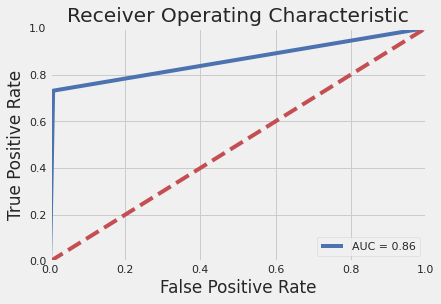

In [70]:
def funct_roc(y_test,preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#     # method II: ggplot
#     from ggplot import *
#     df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
#     ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')
    
funct_roc(y_test,preds)

### Feature Importance:

**1. Using the embedded FI:**

In [73]:
def funct_fi(pipeline,X):
    fi=pipeline.steps[1][1].feature_importances_  ## Returns the list of feature importance from model inside the pipeline
    feat_importances = pd.Series(fi, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh')
    
funct_fi(pipe,X)

ValueError: Length of values (26) does not match length of index (11)

**2. Using SHAP Package:**

In [77]:
def shap_fe(X,y,pipeline):
    # compute SHAP values

    explainer = shap.TreeExplainer(pipeline.steps[1][1])
    shap_values = explainer.shap_values(X)

    # explainer = shap.Explainer(model)
    # shap_values = explainer(X)

    shap.summary_plot(shap_values, X, class_names= [0,1], feature_names = X.columns,show=False)

    vals= np.abs(shap_values[1]).mean(0)
    df_feature_importance=pd.DataFrame(np.concatenate([np.array(df.columns).reshape(-1,1),vals.reshape(-1,1)],axis=1),columns=["Feature","Shap_Scores"])
    df_feature_importance = df_feature_importance.sort_values('Shap_Scores',ascending=False)
    df_feature_importance.reset_index(drop=True,inplace=True)
    return df_feature_importance

shap_fi=shap_fe(X,y,pipe)

TypeError: shap_values() got an unexpected keyword argument 'enable_categorical'

In [76]:
## Printing out the feature importance of each independent variable according to SHAP:
shap_fi

NameError: name 'shap_fi' is not defined